## Adapted from arch univariate_volatility_modeling


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

### Use sqlalchemy to read USEQ_HIST database

In [3]:
from sqlalchemy import create_engine

engine = create_engine('mysql+pymysql://localhost', connect_args={'read_default_file': '~/.myuseq.cnf'})
conn = engine.connect()

In [4]:
import pandas as pd

SQL_query = pd.read_sql_query(
    '''select tradedate, pct_close from USEQ_HIST where symbol='MS'
    and volume>0 order by tradedate''',
    conn,
    index_col='tradedate'
)

df = pd.DataFrame(SQL_query, columns=['pct_close'])

df.head()


,pct_close
tradedate,
2001-01-02,-8.99684
2001-01-03,16.04270
2001-01-04,5.97443
2001-01-05,-4.58902
2001-01-08,-1.47719


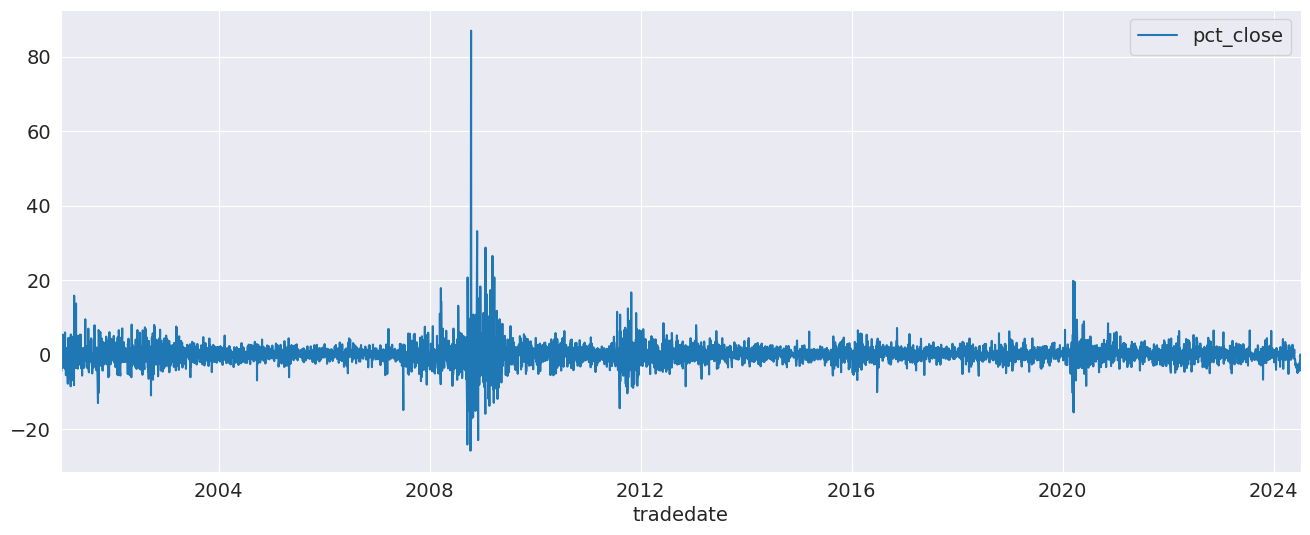

In [5]:
ax = df.plot()
xlim = ax.set_xlim(df.index.min(), df.index.max())

In [6]:
from arch import arch_model

am = arch_model(df)
res = am.fit(update_freq=5)
print(res.summary())
print("likelihood ", res.loglikelihood)

Iteration:      5,   Func. Count:     34,   Neg. LLF: 12805.040968713009
Iteration:     10,   Func. Count:     64,   Neg. LLF: 12734.057854254488
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12734.057818553418
            Iterations: 12
            Function evaluations: 74
            Gradient evaluations: 12
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              pct_close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12734.1
Distribution:                  Normal   AIC:                           25476.1
Method:            Maximum Likelihood   BIC:                           25502.9
                                        No. Observations:                 5913
Date:                Wed, Aug 07 2024   Df Residuals:                     5912
Time:       

`plot()` can be used to quickly visualize the standardized residuals and conditional volatility.


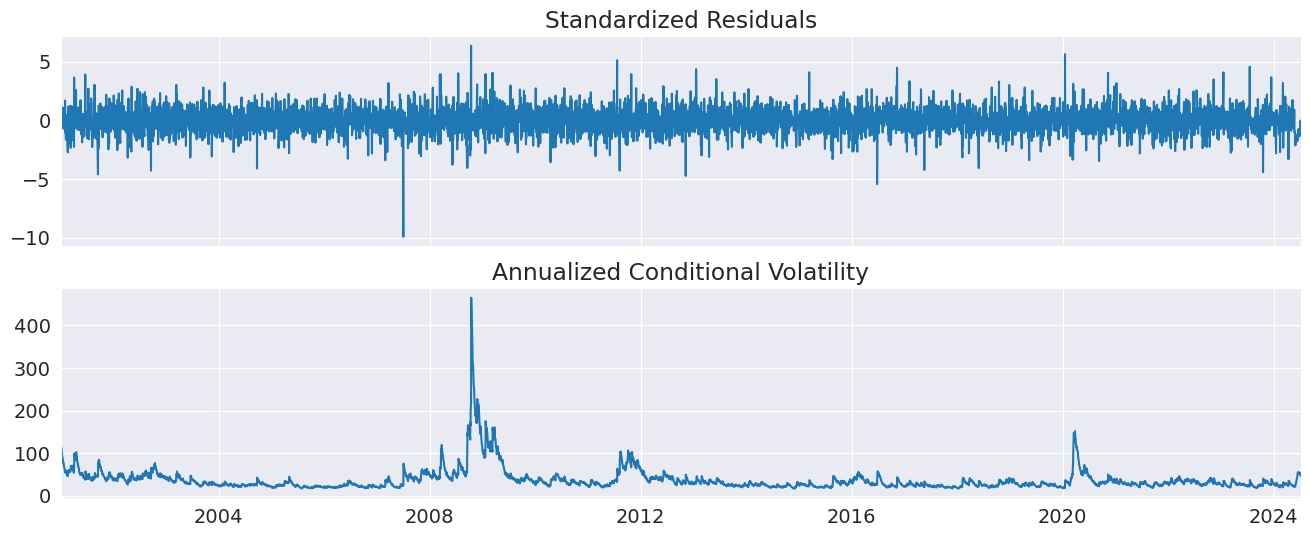

In [7]:
fig = res.plot(annualize="D")

## Forecasts

In [8]:
forecasts = res.forecast(reindex=False)
print(forecasts.mean.iloc[-3:])
print(forecasts.residual_variance.iloc[-3:])
print(forecasts.variance.iloc[-3:])

forecasts = res.forecast(horizon=5, reindex=False)
print(forecasts.residual_variance.iloc[-3:])

                 h.1
tradedate           
2024-07-05  0.079181
                 h.1
tradedate           
2024-07-05  7.898715
                 h.1
tradedate           
2024-07-05  7.898715
                 h.1       h.2       h.3       h.4       h.5
tradedate                                                   
2024-07-05  7.898715  7.881975  7.865437  7.849099  7.832958


### GJR-GARCH

In [9]:
am = arch_model(df, p=1, o=1, q=1)
res = am.fit(update_freq=5, disp="off")
print(res.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:              pct_close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -12666.8
Distribution:                  Normal   AIC:                           25343.5
Method:            Maximum Likelihood   BIC:                           25377.0
                                        No. Observations:                 5913
Date:                Wed, Aug 07 2024   Df Residuals:                     5912
Time:                        01:08:52   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0235  2.305e-02      1.019      0.308 

## Forecasts

In [10]:
forecasts = res.forecast(reindex=False)
print(forecasts.mean.iloc[-3:])

forecasts = res.forecast(horizon=5, reindex=False)
print(forecasts.residual_variance.iloc[-3:])

                 h.1
tradedate           
2024-07-05  0.023484
                  h.1        h.2        h.3        h.4        h.5
tradedate                                                        
2024-07-05  12.965235  12.892934  12.821447  12.750766  12.680881


The log likelihood improves substantially with the introduction of an asymmetric term, and the parameter estimate is significant.

### TARCH/ZARCH

In [11]:
am = arch_model(df, p=1, o=1, q=1, power=1.0)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     45,   Neg. LLF: 12848.700570607809
Iteration:     10,   Func. Count:     77,   Neg. LLF: 12663.791214699824
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12663.790985559257
            Iterations: 12
            Function evaluations: 89
            Gradient evaluations: 12
                  Constant Mean - TARCH/ZARCH Model Results                   
Dep. Variable:              pct_close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                TARCH/ZARCH   Log-Likelihood:               -12663.8
Distribution:                  Normal   AIC:                           25337.6
Method:            Maximum Likelihood   BIC:                           25371.0
                                        No. Observations:                 5913
Date:                Wed, Aug 07 2024   Df Residuals:                     5912
Time:       

The fit hasn't changed much
### Student's T Errors

Financial returns are often heavy tailed, and a Student's T distribution is a simple method to capture this feature.  The call to `arch` changes the distribution from a Normal to a Students's T.

The standardized residuals appear to be heavy tailed with an estimated degree of freedom near 6. (nu =~ 6 which is 8-2, 2 dofs for mean and std dev?) The log-likelihood also shows a large increase.

In [12]:
am = arch_model(df, p=1, o=1, q=1, power=1.0, dist="StudentsT")
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     49,   Neg. LLF: 12947.315644017333
Iteration:     10,   Func. Count:     86,   Neg. LLF: 12482.24922653667
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12482.24917991274
            Iterations: 14
            Function evaluations: 117
            Gradient evaluations: 13
                     Constant Mean - TARCH/ZARCH Model Results                      
Dep. Variable:                    pct_close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      TARCH/ZARCH   Log-Likelihood:               -12482.2
Distribution:      Standardized Student's t   AIC:                           24976.5
Method:                  Maximum Likelihood   BIC:                           25016.6
                                              No. Observations:                 5913
Date:                      Wed, Aug 07 2024   Df R

## GJR-Garch with Student's T

In [13]:
am = arch_model(df, p=1, o=1, q=1, dist="StudentsT")
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     43,   Neg. LLF: 21925.954159194865
Iteration:     10,   Func. Count:     83,   Neg. LLF: 12991.480320002545
Iteration:     15,   Func. Count:    123,   Neg. LLF: 12486.595273500756
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12486.595259408448
            Iterations: 17
            Function evaluations: 137
            Gradient evaluations: 17
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                    pct_close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -12486.6
Distribution:      Standardized Student's t   AIC:                           24985.2
Method:                  Maximum Likelihood   BIC:                           25025.3
                                              No. Observatio

## Forecasts

In [14]:
forecasts = res.forecast(reindex=False)
print(forecasts.mean.iloc[-3:])

forecasts = res.forecast(horizon=5, reindex=False)
print(forecasts.residual_variance.iloc[-3:])


                h.1
tradedate          
2024-07-05  0.02915
                  h.1       h.2        h.3       h.4        h.5
tradedate                                                      
2024-07-05  13.531178  13.48297  13.435118  13.38762  13.340473


## Fixing Parameters
In some circumstances, fixed rather than estimated parameters might be of interest.  A model-result-like class can be generated using the `fix()` method.  The class returned is identical to the usual model result class except that information about inference (standard errors, t-stats, etc) is not available.

In [15]:
fixed_res = am.fix([0.0235, 0.01, 0.06, 0.0, 0.9382, 8.0])
print(fixed_res.summary())

                       Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                     pct_close   R-squared:                          --
Mean Model:                    Constant Mean   Adj. R-squared:                     --
Vol Model:                         GJR-GARCH   Log-Likelihood:               -12559.2
Distribution:       Standardized Student's t   AIC:                           25130.3
Method:            User-specified Parameters   BIC:                           25170.4
                                               No. Observations:                 5913
Date:                       Wed, Aug 07 2024                                         
Time:                               01:08:52                                         
      Mean Model     
                 coef
---------------------
mu             0.0235
   Volatility Model  
                 coef
---------------------
omega          0.0100
alpha[1]       0.0600
gamma[1]       0.0000
beta[1

(11324.0, 19909.0)

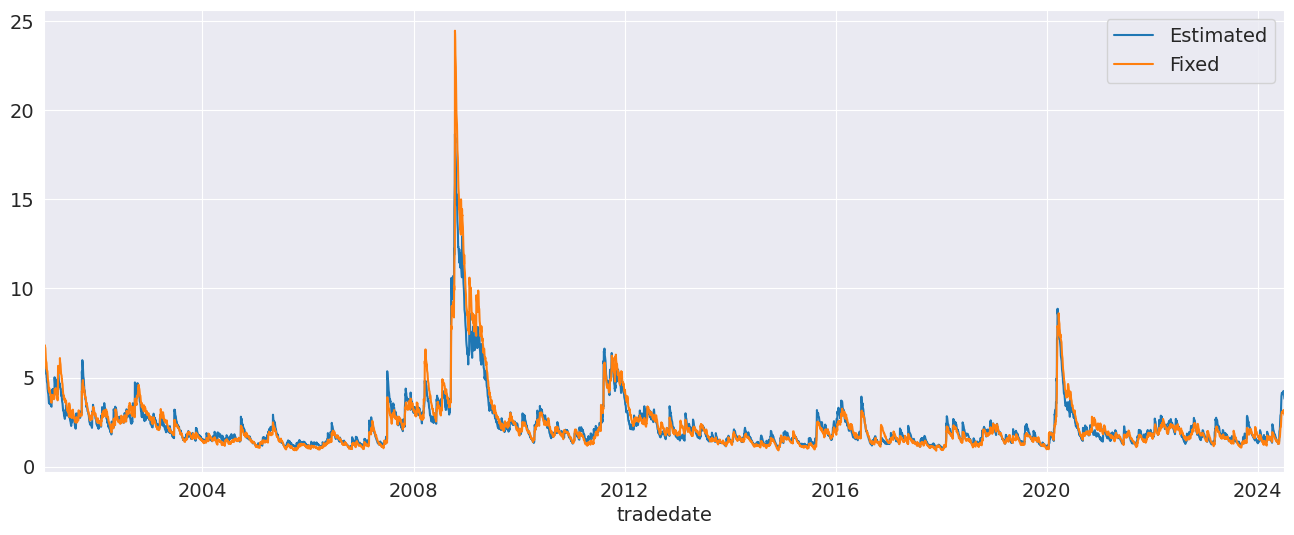

In [16]:
import pandas as pd

df = pd.concat([res.conditional_volatility, fixed_res.conditional_volatility], axis=1)
df.columns = ["Estimated", "Fixed"]
subplot = df.plot()
subplot.set_xlim(xlim)

## Close database

In [17]:
conn.close()